# Produce a world market research with Python

## <i>Analysis</i>

My mission here for <i>La Poule qui chante</i> is to analyze the global chicken market to help them choose their direction for international development.

All data have been sourced from www.fao.org for the year 2017.

In the previous section, we selected 10 variables to identify potential international export customer countries for La Poule qui chante. We have collected and prepared data from a total of 170 countries.

In this part, we will :

1/ Performs a Principal component analysis (PCA) in order to visualize and study the correlations between our variables<br>
2/ Perform an Agglomerative Hierarchical Clustering (AHC) and then a K-means clustering<br>
3/ Compare the two methods and give recommendations

 <br>
 
<u> Summary</u> :

 Tools [(here)](#another_cell_0)
 
  II. World market research data, analysis</a><br>
     -- A. Pre-processing<br>
     ---- 1. Anomaly detection [(here)](#another_cell_a)<br>
     ---- 2. Data standardization [(here)](#another_cell_b)<br>
     -- B. Principal component analysis (PCA)<br>
     ---- 1. Explained Variance Ratio and Scree plot [(here)](#another_cell_c)<br>
     ---- 2. Correlation circles and projections of points [(here)](#another_cell_d)<br>
     -- C. Clustering<br>
     ---- 1. Hierarchical Ascending Classification (HAC) [(here)](#another_cell_e)<br>
     ---- 2. K-means clustering [(here)](#another_cell_f)<br>
     ---- 3. Comparison of the two methods [(here)](#another_cell_g)<br>
     ---- 4. The best countries selected for internationalization [(here)](#another_cell_h)<br>
     ---- 5. Final recommendations [(here)](#another_cell_i)<br> 
 
 

 <a id='another_cell_0'></a>

### Tools

In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Display correlation circles, one for each factorial plane'''

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialize the matplotlib figure
            #fig, ax = plt.subplots(figsize=(8,8))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialize the matplotlib figure      
            #fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            #plt.show(block=False)
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
   

def append_class(df, class_name, feature, thresholds, names):
    '''Append a new class feature named 'class_name' based on a threshold split of 'feature'.Threshold values are in 'thresholds' and class names are in 'names'.'''
    
    n = pd.cut(df[feature], bins = thresholds, labels=names)
    df[class_name] = n

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    #plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

## II. World market research data, analysis

### A. Pre-processing

- Loading file:

In [3]:
chicken = pd.read_csv('export_chicken.csv', sep=';')
X = chicken.groupby(by="Zone").sum()
X.head()

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
Zone,,,,,,,,,,
Afghanistan,55000,57000,1.53,28000.0,0.0,29000,36296113.0,-2.80,2058.4,6.957529
Afrique du Sud,2035000,2118000,35.69,1667000.0,63000.0,514000,57009756.0,-0.28,13860.3,6.902628
Albanie,47000,47000,16.36,13000.0,0.0,38000,2884169.0,0.38,12771.0,3.924577
Algérie,264000,277000,6.38,275000.0,0.0,2000,41389189.0,-0.92,11737.4,5.040496
Allemagne,1609000,1739000,19.47,1514000.0,646000.0,842000,82658409.0,0.59,53071.5,2.762497


<a id='another_cell_a'></a>

#### 1. Anomaly detection

In [4]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
model.fit(X)
outliers = model.predict(X) == -1 
out = X[outliers]
out

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
Zone,,,,,,,,,,
Brésil,9982000,9982000,48.03,14201000.0,4223000.0,3000,2.078338e+08,-0.47,14524.6,0.949267
"Chine, continentale",17518000,18161000,12.33,18236000.0,576000.0,452000,1.421022e+09,0.00,14520.8,-0.193079
Inde,2965000,3661000,2.22,3545000.0,4000.0,0,1.338677e+09,-0.76,6182.9,1.822213
États-Unis d'Amérique,18100000,18266000,55.68,21914000.0,3692000.0,123000,3.250848e+08,0.29,59914.8,-0.195678


<div class="alert-warning">
<u>Important</u> :<br>
We decide to not exclude these outliers from our dataframe for the analysis because these 4 countries can be potential customers for <i>La Poule qui chante</i>

<a id='another_cell_b'></a>

#### 2. Data standardization

In [5]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check
pd.DataFrame(X_scaled, columns=X.columns).describe().round(2)

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
count,170.00,170.00,170.00,170.00,170.00,170.00,170.00,170.00,170.00,170.00
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.31,-0.31,-1.28,-0.29,-0.23,-0.48,-0.28,-3.21,-0.95,-0.29
25%,-0.30,-0.30,-0.87,-0.28,-0.23,-0.46,-0.26,-0.63,-0.74,-0.18
50%,-0.26,-0.27,-0.14,-0.26,-0.23,-0.40,-0.22,0.07,-0.34,-0.12
75%,-0.14,-0.15,0.62,-0.13,-0.20,-0.04,-0.09,0.80,0.42,-0.04
max,8.19,8.06,3.28,8.55,8.97,5.26,8.98,1.86,5.14,12.81


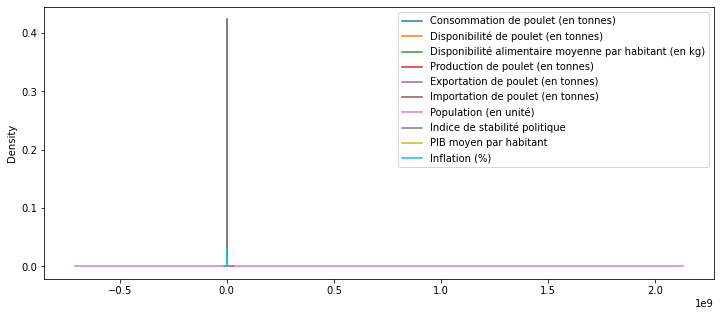

In [6]:
# Before standardisation
X1 = pd.DataFrame(X,columns=X.columns)
X1.plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

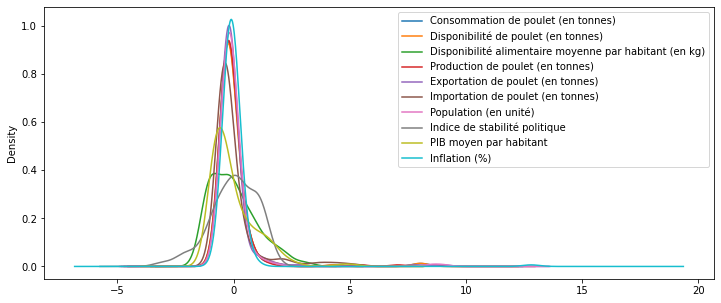

In [7]:
# After standardisation
pd.DataFrame(X_scaled,columns=X.columns).plot(kind='density',sharex=True,figsize=(12,5),layout=(10,1))
plt.show()

In [8]:
pd.DataFrame(X_scaled, index=X.index,columns=X.columns).head()

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
Zone,,,,,,,,,,
Afghanistan,-0.282618,-0.289165,-1.190622,-0.277627,-0.228559,-0.325217,-0.044439,-3.056457,-0.847625,-0.003753
Afrique du Sud,0.646850,0.655926,0.967543,0.383122,-0.091385,2.280627,0.090516,-0.240512,-0.278237,-0.005237
Albanie,-0.286373,-0.293750,-0.253690,-0.283674,-0.228559,-0.276861,-0.262126,0.496997,-0.330790,-0.085731
Algérie,-0.184507,-0.188282,-0.884208,-0.178051,-0.228559,-0.470284,-0.011256,-0.955673,-0.380657,-0.055569
Allemagne,0.446873,0.482132,-0.057206,0.321441,1.178015,4.042929,0.257623,0.731659,1.613526,-0.117140


### B. Principal component analysis (PCA)

<a id='another_cell_c'></a>

#### 1. Explained Variance Ratio and Scree plot

In [9]:
# Import the PCA function from sklearn
from sklearn.decomposition import PCA

# Create the PCA model
model_pca = PCA()

# Fit the model with the data
X_reduced = model_pca.fit_transform(X_scaled)

In [10]:
# Explained variance ratio
model_pca.explained_variance_ratio_.round(2)

array([0.41, 0.21, 0.1 , 0.09, 0.07, 0.06, 0.04, 0.02, 0.  , 0.  ])

In [11]:
# Explained variance ratio cumsum
model_pca.explained_variance_ratio_.cumsum().round(2)

array([0.41, 0.62, 0.72, 0.81, 0.88, 0.94, 0.98, 1.  , 1.  , 1.  ])

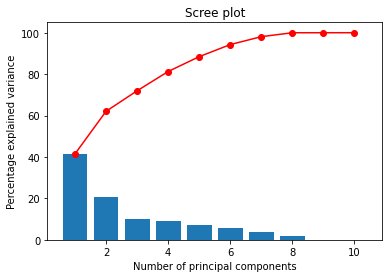

In [12]:
# Scree plot
display_scree_plot(model_pca) 

<div class="alert-success">
<i>We recover 88% inertia from the 5th component</i></br>

In [13]:
# Number of components to study
num_components = 5
pcs = model_pca.components_ 
pc1 = model_pca.components_[0]
pc2 = model_pca.components_[1]
pc3 = model_pca.components_[2]
pc4 = model_pca.components_[3]
pc5 = model_pca.components_[4]

In [14]:
X.columns

Index(['Consommation de poulet (en tonnes)',
       'Disponibilité de poulet (en tonnes)',
       'Disponibilité alimentaire moyenne par habitant (en kg)',
       'Production de poulet (en tonnes)', 'Exportation de poulet (en tonnes)',
       'Importation de poulet (en tonnes)', 'Population (en unité)',
       'Indice de stabilité politique', 'PIB moyen par habitant',
       'Inflation (%)'],
      dtype='object')

In [15]:
pc1

array([ 0.4813054 ,  0.48125532,  0.12992944,  0.48184181,  0.37754306,
        0.16358   ,  0.32557665,  0.01715659,  0.10808837, -0.02025979])

In [16]:
pc2

array([-0.07821054, -0.08357103,  0.47407015, -0.07521518,  0.05866185,
        0.21921488, -0.23880901,  0.56630188,  0.54743567, -0.16610061])

In [17]:
pc3

array([ 2.13825381e-04, -6.50116061e-03,  2.39059194e-01,  1.52665528e-02,
        1.12129342e-01,  7.60079629e-04, -1.87205836e-01, -3.87591192e-02,
        2.69046461e-02,  9.44843692e-01])

In [18]:
pc4

array([-0.02897628, -0.01808078, -0.22358387, -0.13000755, -0.30783285,
        0.84369975,  0.24656534, -0.14456201,  0.16137067,  0.13273388])

In [19]:
pc5

array([ 0.02981068,  0.05238471, -0.08472936, -0.01885847, -0.47404455,
       -0.36437527,  0.60976869,  0.43385582,  0.16146484,  0.21266232])

<a id='another_cell_d'></a>

#### 2. Correlation circles and projections of points

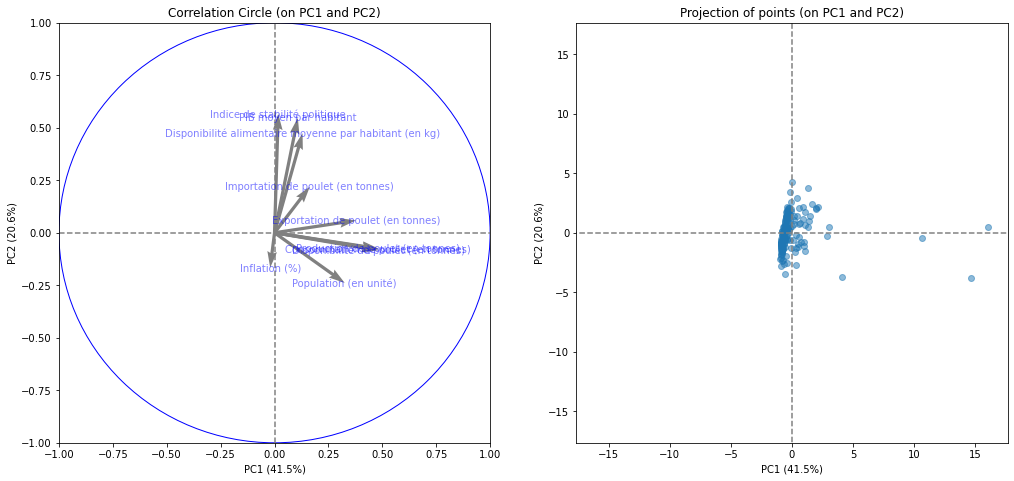

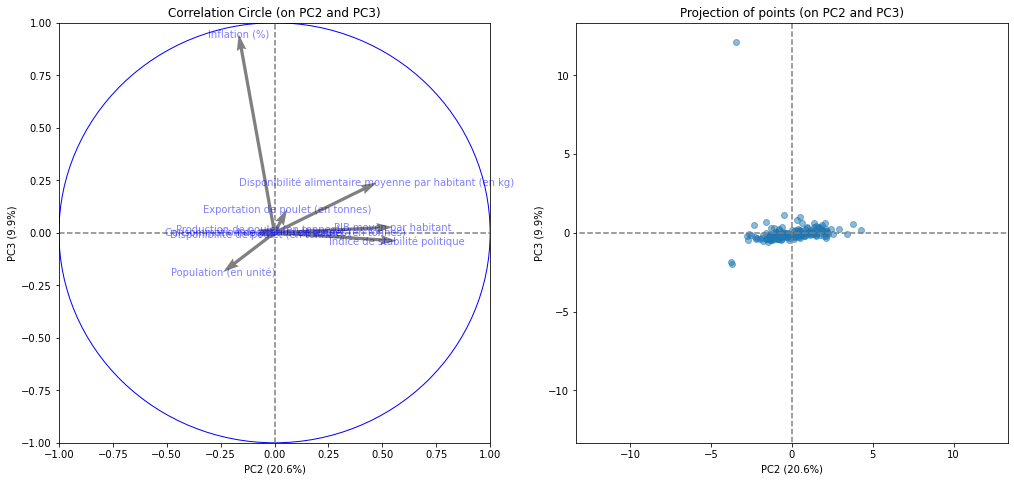

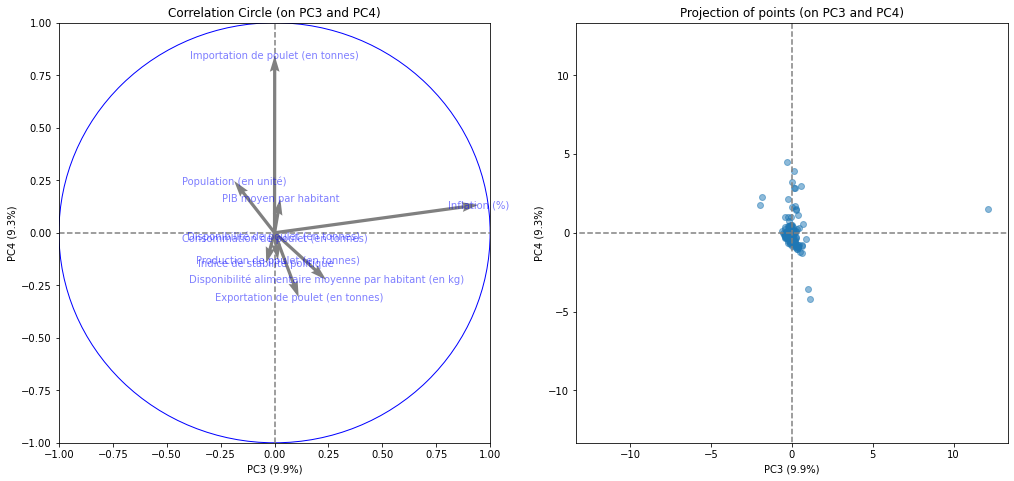

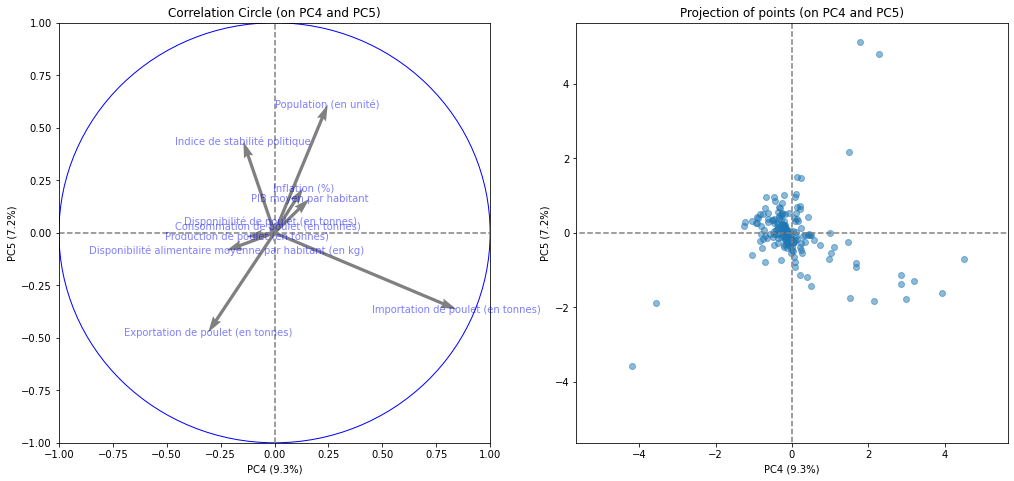

In [20]:
X_projected = model_pca.transform(X_scaled)

plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(0,1)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(0,1)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(1,2)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(1,2)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(2,3)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(2,3)], alpha = 0.5)
plt.show()

print("="*100,"\n")
plt.figure(figsize=(17,17))
plt.subplot(2,2,1)
display_circles(pcs, num_components, model_pca, [(3,4)], labels = np.array(X.columns))
plt.subplot(2,2,2)
display_factorial_planes(X_projected, num_components, model_pca, [(3,4)], alpha = 0.5)
plt.show()

<div class="alert-success">
    <u>Axes interpretation</u> :
<i><br><li><strong> pc1</strong> → Countries with large populations that produce, consume and export a lot of chicken abroad (+ significant domestic availability of chicken)</br></li>
<li><strong> pc2</strong> → Very rich countries with low demography (very good political stability and non-inflationary) which import a lot of chicken from abroad and have a very good average availability of chicken per capita</li>
<li><strong> pc3</strong> → No variable seems strongly correlated to this axis except a strong positive correlation with the "inflation" variable (catch-all category ?)</li>
<li><strong> pc4</strong> → Rather rich countries, which import a lot (because they produce little), do not export chicken abroad and have a fairly low availability of chicken per capita (+ inflation to watch)</li>
<li><strong> pc5</strong> → Rather rich countries with good political stability (+ inflation to watch), which no import and export chicken abroad (or very little)</li>
</i></div>

### C. Clustering

<a id='another_cell_e'></a>

#### 1. Hierarchical Ascending Classification (HAC)

In [74]:
# Import the hierarchical clustering algorithm
from sklearn.cluster import AgglomerativeClustering

# Create a hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

# Fit the data to the model and determine which clusters each data point belongs to:
hiercluster.set_params(n_clusters=5)
clusters = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters) # count of data points in each cluster

array([ 60, 105,   2,   1,   2], dtype=int64)

In [75]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered["cluster"] = clusters

- Dendrogram :

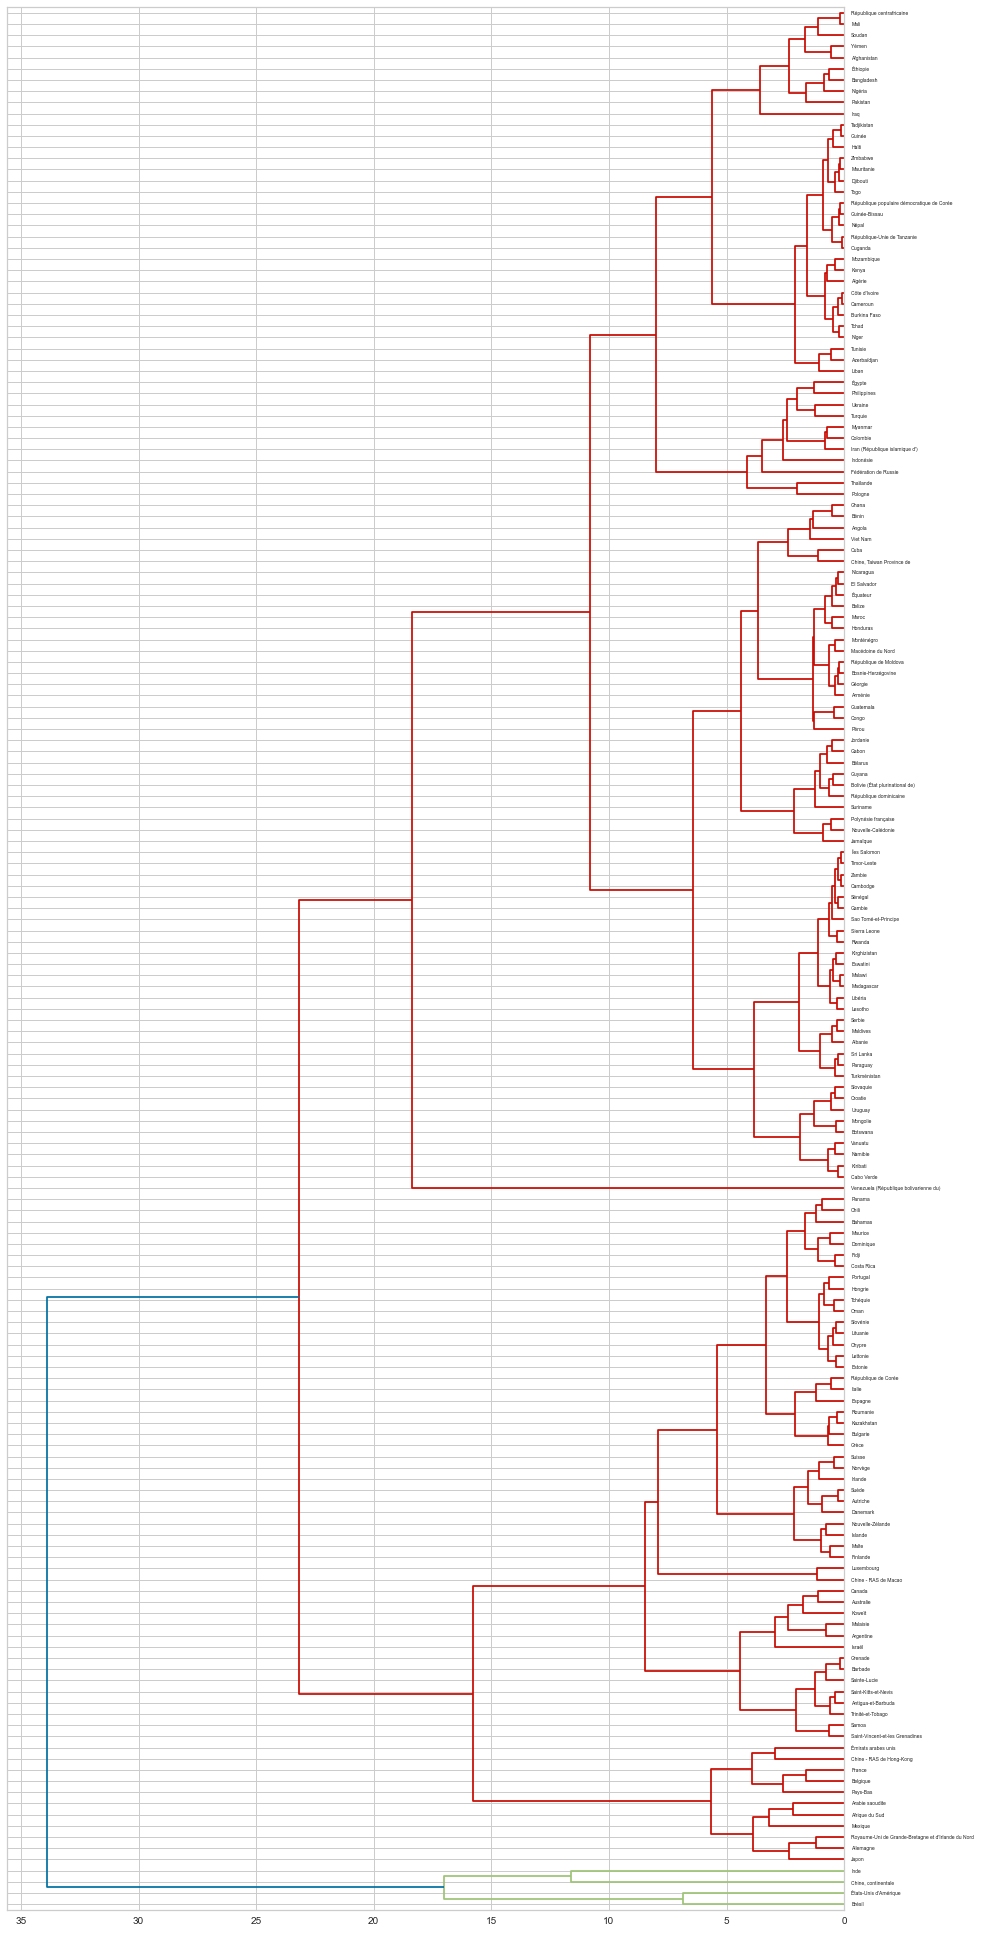

In [76]:
# Show a dendrogram, just for the smallest cluster
from scipy.cluster.hierarchy import linkage, fcluster 
sample = X_clustered
Z = linkage(sample, 'ward') 
names = sample.index
plt.figure(figsize=(15,35))
dendrogram(Z, labels = names, orientation = "left")
plt.show()

- Factorial plane :

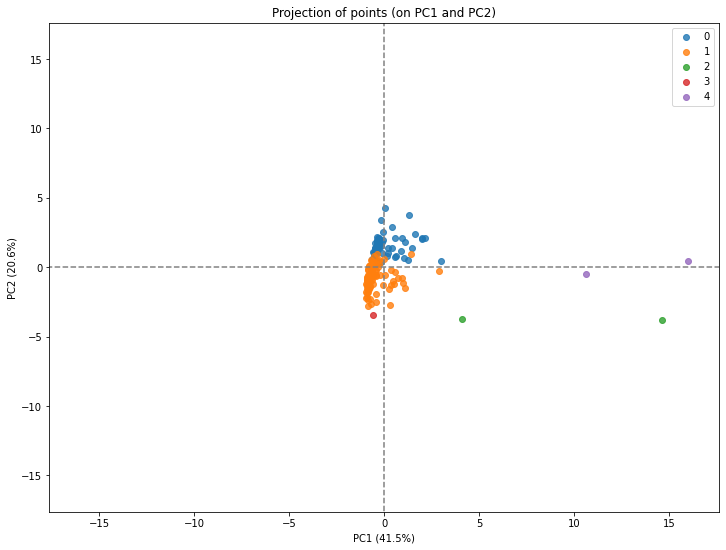

In [24]:
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
#X_clustered.boxplot(by="cluster", figsize=(15,10), layout=(2,5))

- Centroid analysis :

In [25]:
hac_ =  X_clustered.groupby(by="cluster").mean()
display(hac_)

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
cluster,,,,,,,,,,
0,-0.067956,-0.069209,0.772186,-0.087754,0.002205,0.451701,-0.161826,0.806155,0.955686,-0.134731
1,-0.166267,-0.166839,-0.463309,-0.160689,-0.166535,-0.266064,-0.100282,-0.440587,-0.544731,-0.038274
2,4.499210,4.688039,-0.827663,4.101495,0.402876,0.733239,8.709146,-0.352256,-0.447503,-0.169791
3,-0.028657,-0.028245,-0.006032,-0.047030,-0.228559,-0.346708,-0.089353,-1.346776,-0.946933,12.805408
4,6.282801,6.161391,1.988818,6.990809,8.388341,-0.142539,1.455132,-0.028199,0.848749,-0.181623


<div class="alert-success">
    <u>Clusters interpretation</u> :
<i><br><li><strong> Cluster 0</strong> → very stable countries with high GDP</br></li>
<li><strong> Cluster 1</strong> → low stable countries with low GDP, low demographics and low chicken consumption</li>
<li><strong> Cluster 2</strong> → countries with large populations and low average GDP per capita, very large consumers of chicken</li>
<li><strong> Cluster 3</strong> → poor, unstable and highly inflationary country</li>
<li><strong> Cluster 4</strong> → rather rich and stable countries, very large consumers, producers and exporters of chickens abroad</li>
</i></div>

- Clusters composition :

In [26]:
print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 0 :".format(f =len(X_clustered[X_clustered["cluster"]==0]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==0].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 1 :".format(f =len(X_clustered[X_clustered["cluster"]==1]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==1].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 2 :".format(f =len(X_clustered[X_clustered["cluster"]==2]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==2].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 3 :".format(f =len(X_clustered[X_clustered["cluster"]==3]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==3].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 4 :".format(f =len(X_clustered[X_clustered["cluster"]==4]))+"\033[0;0m","\n")
print(X_clustered[X_clustered["cluster"]==4].index.tolist(),"\n")
print("="*100,"\n")


The 60 countries of cluster 0 : 

['Afrique du Sud', 'Allemagne', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine', 'Australie', 'Autriche', 'Bahamas', 'Barbade', 'Belgique', 'Bulgarie', 'Canada', 'Chili', 'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chypre', 'Costa Rica', 'Danemark', 'Dominique', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'France', 'Grenade', 'Grèce', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Italie', 'Japon', 'Kazakhstan', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Malaisie', 'Malte', 'Maurice', 'Mexique', 'Norvège', 'Nouvelle-Zélande', 'Oman', 'Panama', 'Pays-Bas', 'Portugal', 'Roumanie', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'République de Corée', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Slovénie', 'Suisse', 'Suède', 'Tchéquie', 'Trinité-et-Tobago', 'Émirats arabes unis'] 


The 105 countries of cluster 1 : 

['Afghanistan', 'Albanie', 'Algérie', 'Angola', 'Arménie', 'Azerbaïdjan', 'B

- Conclusion (HAC) and recommendations for <i>La Poule qui chante</i> :

<div class="alert-success">
<i><li><strong> Cluster 0</strong> → these countries are rich and stable</li>
<li><strong> Cluster 2</strong> → these countries have an average GDP but very high chicken consumption</li>
The two clusters present the best characteristics for an internationalization.<br> They generally display good political stability, a high or even very high GDP for some, and finally they are the biggest importers of chicken.

<div class="alert-warning">
<strong>The cluster 1</strong> comes in 3rd position with low economic power and low purchasing power.<br>
<strong>The cluster 4</strong> comes in 4th position because of their position of first chicken exporting powers.<br>
<strong>The cluster 3</strong> comes in 5th position with very poor and hyper inflationary countries.<br>

<a id='another_cell_f'></a>

#### 2. K-means clustering

- Finding the optimal number of clusters for classification (Elbow method) :

In [27]:
!pip install yellowbrick

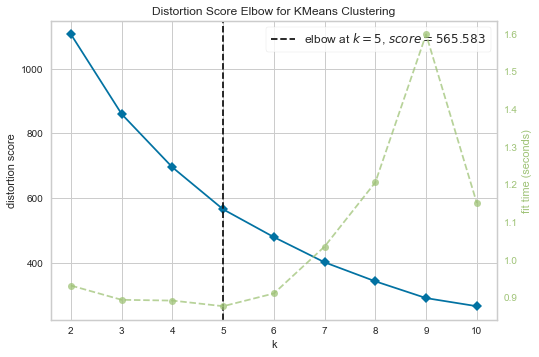

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X_scaled)
model.show()

<div class="alert-success">
    <u>Notice</u> :
<i><br><li>According to the elbow curve, the optimal number of clusters is 5, but with regard to the silhouette score, it can be 7 too</br></li>
</i></div>

In [29]:
# K-Means model with 5 clusters
model_kmeans = KMeans(n_clusters=5)
model_kmeans.fit(X_scaled)

# Determine which clusters each data point belongs to
clusters2 =  model_kmeans.fit_predict(X_scaled)

# Add the cluster number to the original scaled data
X_clustered2 = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered2["cluster"] = clusters2

X_clustered2.head()

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%),cluster
Zone,,,,,,,,,,,
Afghanistan,-0.282618,-0.289165,-1.190622,-0.277627,-0.228559,-0.325217,-0.044439,-3.056457,-0.847625,-0.003753,4
Afrique du Sud,0.646850,0.655926,0.967543,0.383122,-0.091385,2.280627,0.090516,-0.240512,-0.278237,-0.005237,0
Albanie,-0.286373,-0.293750,-0.253690,-0.283674,-0.228559,-0.276861,-0.262126,0.496997,-0.330790,-0.085731,4
Algérie,-0.184507,-0.188282,-0.884208,-0.178051,-0.228559,-0.470284,-0.011256,-0.955673,-0.380657,-0.055569,4
Allemagne,0.446873,0.482132,-0.057206,0.321441,1.178015,4.042929,0.257623,0.731659,1.613526,-0.117140,0


In [30]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])
X_reduceddf['cluster'] = clusters2
X_reduceddf.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,cluster
Zone,,,,,,,,,,,
Afghanistan,-0.861595,-2.765648,-0.212490,0.405298,-1.181427,0.069632,1.370000,-0.019790,0.001381,0.006786,4
Afrique du Sud,1.271255,0.509781,0.204453,1.667049,-0.918437,-1.227112,-0.377598,-0.309097,-0.005660,-0.019025,0
Albanie,-0.691262,0.051118,-0.149061,-0.257257,0.196294,0.087700,-0.506930,-0.048803,-0.007931,-0.002340,4
Algérie,-0.603392,-1.229786,-0.262494,-0.030252,-0.152148,0.338377,0.356799,-0.081267,-0.003657,0.001674,4
Allemagne,1.973862,2.084412,-0.020499,3.200299,-1.284071,0.786741,-0.643918,0.568484,0.001189,-0.042235,0


- Factorial plane :

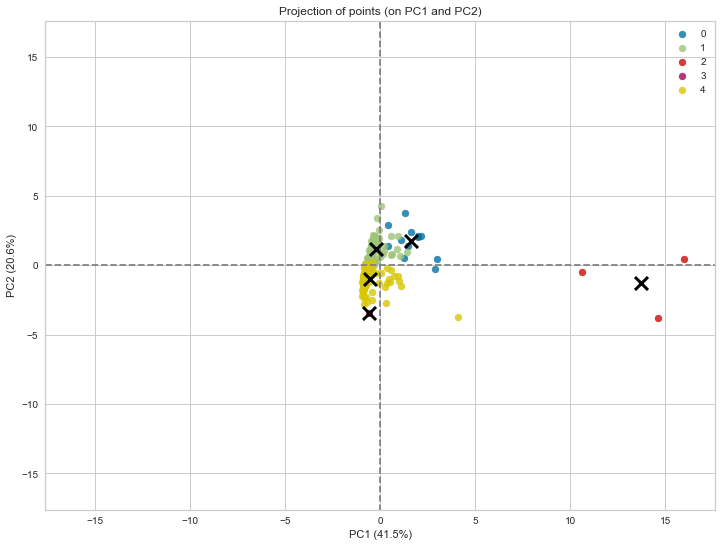

In [31]:
centres_reduced = model_pca.transform(model_kmeans.cluster_centers_)
plt.figure(figsize=(12,9))
display_factorial_planes(X_reduced, 2, model_pca, [(0,1)], illustrative_var = clusters2, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

- Centroid analysis :

In [32]:
kmeans_ =  X_clustered2.groupby(by="cluster").mean()
display(kmeans_)

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%)
cluster,,,,,,,,,,
0,0.509698,0.506474,0.636069,0.346167,0.595935,3.063275,0.124866,0.334037,1.163147,-0.126863
1,-0.179474,-0.181954,0.751882,-0.165231,-0.122907,-0.192466,-0.219871,0.802659,0.579162,-0.122497
2,6.826868,6.778459,1.156446,7.014796,5.934094,0.554143,3.962553,0.005324,0.483709,-0.186758
3,-0.028657,-0.028245,-0.006032,-0.047030,-0.228559,-0.346708,-0.089353,-1.346776,-0.946933,12.805408
4,-0.167444,-0.163571,-0.673803,-0.161925,-0.188045,-0.287245,0.011179,-0.616298,-0.585477,-0.031016


<div class="alert-success">
    <u>Clusters interpretation</u> :
<i><li><strong> Cluster 0</strong> → very rich countries with high GDP, very high importers of chicken</li>
<li><strong> Cluster 1</strong> → rather rich and stable countries but low chicken consumers</li>
<li><strong> Cluster 2</strong> → major economic powers with a fairly good purchasing power per capita, very large consumers, producers and exporters of chicken, but also good importers</li>
<li><strong> Cluster 3</strong> → poor, unstable and highly inflationary country</li>
<li><strong> Cluster 4</strong> → poor and unstable countries</li>
</i>

- Clusters composition :

In [33]:
print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 0 :".format(f =len(X_clustered2[X_clustered2["cluster"]==0]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==0].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 1 :".format(f =len(X_clustered2[X_clustered2["cluster"]==1]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==1].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 2 :".format(f =len(X_clustered2[X_clustered2["cluster"]==2]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==2].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 3 :".format(f =len(X_clustered2[X_clustered2["cluster"]==3]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==3].index.tolist(),"\n")

print("="*100,"\n")
print("\033[1m"+"The {f} countries of cluster 4 :".format(f =len(X_clustered2[X_clustered2["cluster"]==4]))+"\033[0;0m","\n")
print(X_clustered2[X_clustered2["cluster"]==4].index.tolist(),"\n")
print("="*100,"\n")


The 12 countries of cluster 0 : 

['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Belgique', 'Chine - RAS de Hong-Kong', 'France', 'Fédération de Russie', 'Japon', 'Mexique', 'Pays-Bas', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Émirats arabes unis'] 


The 65 countries of cluster 1 : 

['Antigua-et-Barbuda', 'Argentine', 'Australie', 'Autriche', 'Bahamas', 'Barbade', 'Bolivie (État plurinational de)', 'Bulgarie', 'Bélarus', 'Cabo Verde', 'Canada', 'Chili', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chypre', 'Costa Rica', 'Croatie', 'Cuba', 'Danemark', 'Dominique', 'Espagne', 'Estonie', 'Fidji', 'Finlande', 'Gabon', 'Grenade', 'Guyana', 'Hongrie', 'Irlande', 'Islande', 'Israël', 'Italie', 'Jamaïque', 'Kazakhstan', 'Kiribati', 'Koweït', 'Lettonie', 'Lituanie', 'Luxembourg', 'Malaisie', 'Malte', 'Maurice', 'Norvège', 'Nouvelle-Calédonie', 'Nouvelle-Zélande', 'Oman', 'Panama', 'Pologne', 'Polynésie française', 'Portugal', 'Roumanie', 'République de Corée', 'R

- Conclusion (K-Means) and recommendations for <i>La Poule qui chante</i> :

<div class="alert-success">
<i><li><strong> Cluster 0</strong> → very rich countries with high GDP, very high importers of chicken</li>
<li><strong> Cluster 2</strong> → major economic powers with a fairly good purchasing power per capita, very large consumers, producers and exporters of chicken, but also good importers</li>
The two clusters present the best characteristics for an internationalization.<br> They generally display good political stability, a high or even very high GDP for some, and finally they are the biggest importers of chicken.

<div class="alert-warning">
<strong>The cluster 1</strong> comes in 3rd position with low chicken consumers even if they are rich and stable countries.<br>
<strong>The cluster 4</strong> comes in 4th position with poor and unstable countries.<br>
<strong>The cluster 3</strong> comes in 5th position with very poor and hyper inflationary countries.<br>

<a id='another_cell_g'></a>

#### 3. Comparison of the two methods

In [59]:
# Number of countries by cluster (HAC)
hac2 = pd.pivot_table(X_clustered, index="cluster", aggfunc="count")
hac2.drop(columns =['Consommation de poulet (en tonnes)', 'Disponibilité alimentaire moyenne par habitant (en kg)', 'Disponibilité de poulet (en tonnes)', 'Exportation de poulet (en tonnes)', 'Importation de poulet (en tonnes)', 'Indice de stabilité politique', 'Inflation (%)', 'PIB moyen par habitant', 'Population (en unité)'], inplace=True)
hac2.rename(columns={"Production de poulet (en tonnes)":"Number_of_countries (HAC)"}, inplace= True)
# Number of countries per cluster (Kmeans)
kmeans2 = pd.pivot_table(X_clustered2, index="cluster", aggfunc="count")
kmeans2.drop(columns =['Consommation de poulet (en tonnes)', 'Disponibilité alimentaire moyenne par habitant (en kg)', 'Disponibilité de poulet (en tonnes)', 'Exportation de poulet (en tonnes)', 'Importation de poulet (en tonnes)', 'Indice de stabilité politique', 'Inflation (%)', 'PIB moyen par habitant', 'Population (en unité)'], inplace=True)
kmeans2.rename(columns={"Production de poulet (en tonnes)":"Number_of_countries (Kmeans)"},inplace= True)
# Merge and display
countries_clusters = hac2.merge(kmeans2, how='left', on='cluster')
countries_clusters

,Number_of_countries (HAC),Number_of_countries (KMeans)
cluster,,
0,60,12
1,105,65
2,2,3
3,1,1
4,2,89


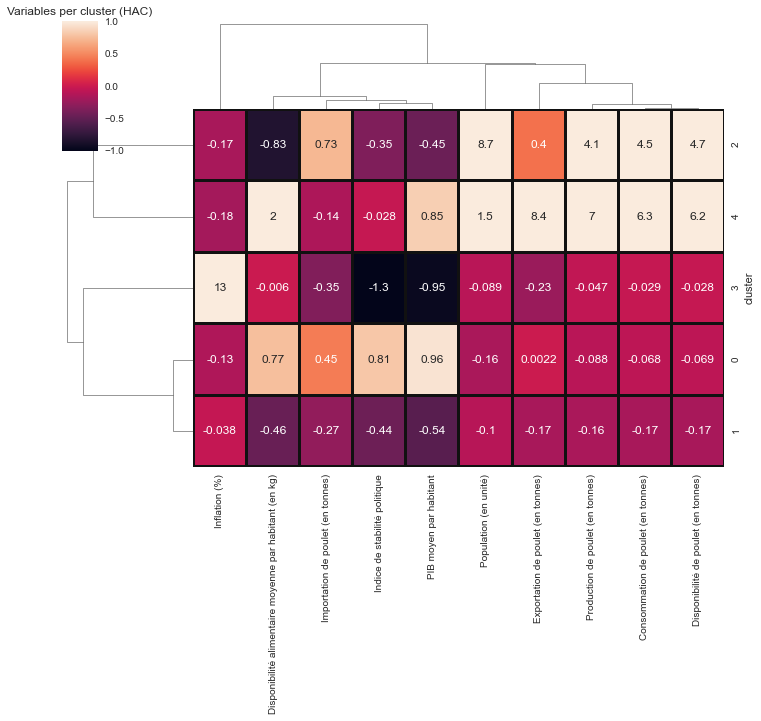

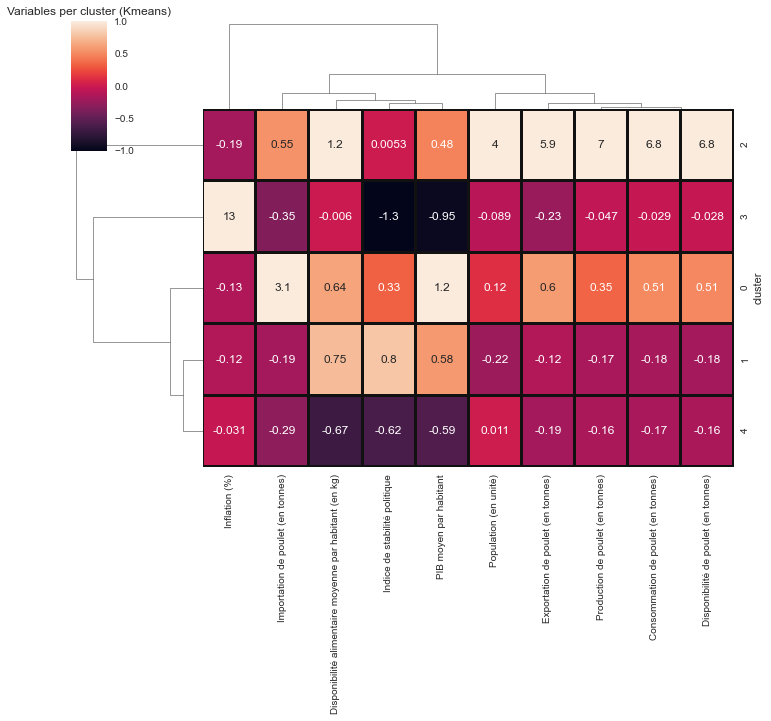

In [62]:
# Variables per cluster (HAC)
sns.clustermap(hac_, annot=True, linecolor='k', linewidths=2, vmin=-1, vmax=1)
plt.title("Variables per cluster (HAC)")
plt.savefig("hac.png")
plt.show()

# Variables per cluster (Kmeans)
sns.clustermap(kmeans_, annot=True, linecolor='k', linewidths=2, vmin=-1, vmax=1)
plt.title("Variables per cluster (Kmeans)")
plt.savefig("kmeans.png")
plt.show()

<div class="alert-warning">
<u>Warning</u> :<br>
Cluster 3 is outclassed in both methods because of the average of its "Inflation" variable

<div class="alert-success">
<u>Notice</u> :<br>
Depending on the chosen method, the clusters have different characteristics and sizes.<br>
The Kmeans method offers us a finer selection of its clusters.
<i><li><strong> HAC best clusters</strong> → Cluster 0 (60 countries) and cluster 2 (2 countries)</li>
<li><strong> Kmeans best clusters</strong> → Cluster 0 (12 countries) and cluster 2 (3 countries)</li>

<a id='another_cell_h'></a>

#### 4. The best countries selected for internationalization

Below are the 15 countries of the best clusters of each method that import the most chicken in the world.

- HAC top 15 :

In [102]:
X["cluster_hac"] = clusters
X["cluster_kmeans"] = clusters2
hac_top15 = X[X["cluster_hac"].isin([0,2])].sort_values(by="Importation de poulet (en tonnes)",ascending=False).head(15)
hac_top15

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%),cluster_hac,cluster_kmeans
Zone,,,,,,,,,,,,
Japon,2359000,2415000,18.50,2215000.0,10000.0,1069000,1.275027e+08,1.11,41444.2,0.698263,0,0
Mexique,4058000,4219000,32.52,3249000.0,9000.0,972000,1.247773e+08,-0.80,19721.3,6.966624,0,0
Chine - RAS de Hong-Kong,391000,280000,53.51,24000.0,663000.0,907000,7.306322e+06,0.83,59842.2,1.127965,0,0
Allemagne,1609000,1739000,19.47,1514000.0,646000.0,842000,8.265841e+07,0.59,53071.5,2.762497,0,0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,2131000,2234000,31.94,1814000.0,359000.0,779000,6.672746e+07,0.39,46372.4,2.261151,0,0
Arabie saoudite,1435000,1435000,43.36,616000.0,10000.0,722000,3.310118e+07,-0.64,47306.2,-0.821562,0,0
Pays-Bas,346000,372000,20.33,1100000.0,1418000.0,608000,1.702135e+07,0.92,55088.6,2.664326,0,0
Afrique du Sud,2035000,2118000,35.69,1667000.0,63000.0,514000,5.700976e+07,-0.28,13860.3,6.902628,0,0
France,1485000,1573000,22.90,1750000.0,501000.0,506000,6.484251e+07,0.28,44577.1,1.088588,0,0


- Kmeans top 15 :

In [103]:
kmeans_top15 = X[X["cluster_kmeans"].isin([0,2])].sort_values(by="Importation de poulet (en tonnes)",ascending=False).head(15)
kmeans_top15

,Consommation de poulet (en tonnes),Disponibilité de poulet (en tonnes),Disponibilité alimentaire moyenne par habitant (en kg),Production de poulet (en tonnes),Exportation de poulet (en tonnes),Importation de poulet (en tonnes),Population (en unité),Indice de stabilité politique,PIB moyen par habitant,Inflation (%),cluster_hac,cluster_kmeans
Zone,,,,,,,,,,,,
Japon,2359000,2415000,18.50,2215000.0,10000.0,1069000,1.275027e+08,1.11,41444.2,0.698263,0,0
Mexique,4058000,4219000,32.52,3249000.0,9000.0,972000,1.247773e+08,-0.80,19721.3,6.966624,0,0
Chine - RAS de Hong-Kong,391000,280000,53.51,24000.0,663000.0,907000,7.306322e+06,0.83,59842.2,1.127965,0,0
Allemagne,1609000,1739000,19.47,1514000.0,646000.0,842000,8.265841e+07,0.59,53071.5,2.762497,0,0
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,2131000,2234000,31.94,1814000.0,359000.0,779000,6.672746e+07,0.39,46372.4,2.261151,0,0
Arabie saoudite,1435000,1435000,43.36,616000.0,10000.0,722000,3.310118e+07,-0.64,47306.2,-0.821562,0,0
Pays-Bas,346000,372000,20.33,1100000.0,1418000.0,608000,1.702135e+07,0.92,55088.6,2.664326,0,0
Afrique du Sud,2035000,2118000,35.69,1667000.0,63000.0,514000,5.700976e+07,-0.28,13860.3,6.902628,0,0
France,1485000,1573000,22.90,1750000.0,501000.0,506000,6.484251e+07,0.28,44577.1,1.088588,0,0


<a id='another_cell_i'></a>

#### 5. Final recommendations

<div class="alert-success">
We recommend <i>La Poule qui chante</i> to <strong><u>select the first 13 countries of the top 15 (from Japan to Belgium)</u> that have been selected by the two clustering methods</strong>. These 13 countries all seem to be good candidates for internationalization.<br>
La Poule qui chante can refine this selection by favoring the "Europe" region for example and only retain the following countries:<br>
<i>
1. Germany<br>
2. Belgium<br>
3. Netherlands (not to be favored here because also a major chicken exporting power)<br>
4. England (not to be favored here because of Brexit)<br>
</i>    